# COMS 4995_002 Deep Learning Assignment 1
Due on Monday, Oct 9, 11:59pm

This assignment can be done in groups of at most 3 students. Everyone must submit on Courseworks individually.

Write down the UNIs of your group (if applicable)

Member 1: Name, UNI

Member 2: Name, UNI

Member 3: Name, UNI

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import sys
# you shouldn't need to make any more imports

In [5]:
class NeuralNetwork(object):
    """
    Abstraction of neural network.
    Stores parameters, activations, cached values. 
    Provides necessary functions for training and prediction. 
    """
    def __init__(self, layer_dimensions, drop_prob=0.0, reg_lambda=0.0):
        """
        Initializes the weights and biases for each layer
        :param layer_dimensions: (list) number of nodes in each layer
        :param drop_prob: drop probability for dropout layers. Only required in part 2 of the assignment
        :param reg_lambda: regularization parameter. Only required in part 2 of the assignment
        """
        np.random.seed(1)
        
        self.parameters = {}
        self.num_layers =len(layer_dimensions)
        self.drop_prob = drop_prob
        self.reg_lambda = reg_lambda
        self.train_cost = []
        self.validation_cost = []
        self.train_accuracy = []
        self.validation_accuracy = []
        
        # init parameters
        self.parameters = self.init_parameters(layer_dimensions)
        
    def init_parameters(self, layer_dimensions):
        
        parameters = {}
        
        for i in range(len(layer_dimensions) - 1):
            forwoard_unit_number = layer_dimensions[i+1]
            backwoard_unit_number = layer_dimensions[i]
            parameters['W'+str(i+1)] = 0.01 * np.random.randn(forwoard_unit_number, backwoard_unit_number)
            parameters['b'+str(i+1)] = np.zeros((forwoard_unit_number,1))
            
        return parameters

    def affineForward(self, A, W, b):
        """
        Forward pass for the affine layer.
        :param A: input matrix, shape (L, S), where L is the number of hidden units in the previous layer and S is
        the number of samples
        :returns: the affine product WA + b, along with the cache required for the backward pass
        """
        return np.dot(W, A) + b

    def activationForward(self, A, activation="relu"):
        """
        Common interface to access all activation functions.
        :param A: input to the activation function
        :param prob: activation funciton to apply to A. Just "relu" for this assignment.
        :returns: activation(A)
        """ 
        return relu(A)

    def relu(self, X):
        return np.maximum(0,X)
            
    def dropout(self, A, prob):
        """
        :param A: 
        :param prob: drop prob
        :returns: tuple (A, M) 
            WHERE
            A is matrix after applying dropout
            M is dropout mask, used in the backward pass
        """
        M = np.random.rand(A.shape[0], A.shape[1])
        M = 1*(M >= prob)
        A = np.multiply(A, M)
        A = A / (1 - prob)
#         print('forward dropout is working**************')

        return A, M

    
    def forwardPropagation(self, X, dropout = True):
        """
        Runs an input X through the neural network to compute activations
        for all layers. Returns the output computed at the last layer along
        with the cache required for backpropagation.
        :returns: (tuple) AL, cache
            WHERE 
            AL is activation of last layer
            cache is cached values for each layer that
                     are needed in further steps
        """
        cache = {}
        cache['A' + str(0)] = X
        
        for i in range(self.num_layers - 2):
            W = self.parameters['W' + str(i+1)]
            b = self.parameters['b' + str(i+1)]
            A = cache['A' + str(i)]
            Z = self.affineForward(A, W, b)
            A_next = self.relu(Z)
            
            # adding dropout here
            if self.drop_prob > 0 and dropout:
                A_next, M = self.dropout(A_next, self.drop_prob)
                cache['M' + str(i+1)] = M
                
            cache['A' + str(i+1)] = A_next
            cache['Z' + str(i+1)] = Z
        
        W = self.parameters['W' + str(self.num_layers - 1)]
        b = self.parameters['b' + str(self.num_layers - 1)]
        AL = self.affineForward(cache['A' + str(self.num_layers - 2)], W, b)

        return AL, cache
    
    def softmax(self, Z):
        K = Z - np.amax(Z, axis=0)
        K = np.exp(K)
        sum_ = np.sum(K,axis=0, keepdims=True)
        return K / sum_
    
    def costFunction(self, AL, y):
        """
        :param AL: Activation of last layer, shape (num_classes, S)
        :param y: labels, shape (S)
        :param alpha: regularization parameter
        :returns cost, dAL: A scalar denoting cost and the gradient of cost
        """
        # compute loss
        AL = self.softmax(AL)
        y_one_hot = np.zeros((AL.shape[0], AL.shape[1]))
        
        cost = 0
        cost = np.sum(-np.log(np.float64(AL[y, range(len(y))])))/len(y)
        y_one_hot[y, range(len(y))] = 1
        
        if self.reg_lambda > 0:
            for i in range(self.num_layers - 2):
                W = self.parameters['W' + str(i + 1)]
                cost += np.sum(np.multiply(W, W)) * self.reg_lambda / (2 * len(y))

        dAL = AL
        dAL[y, range(len(y))] -= 1
    
        #dAL = AL - y_one_hot
    
        return cost, dAL

    def affineBackward(self, dA_prev, cache, layer_num):
        """
        Backward pass for the affine layer.
        :param dA_prev: gradient from the next layer.
        :param cache: cache returned in affineForward
        :returns dA: gradient on the input to this layer
                 dW: gradient on the weights
                 db: gradient on the bias
        """
        m = dA_prev.shape[1]
        A = cache['A' + str(layer_num-1)]
        W = self.parameters['W' + str(layer_num)]
        
        #add dropout back propagation here
        if self.drop_prob > 0:
            dA_prev = self.dropout_backward(dA_prev, cache, layer_num)
        
        dZ = self.activationBackward(dA_prev, cache, layer_num)
        dW = 1 / m * np.dot(dZ, A.T)
        db = 1 / m * np.sum(dZ, axis = 1, keepdims = True)
        dA = np.dot(W.T, dZ)

        return dA, dW, db

    def activationBackward(self, dA, cache, layer_num, activation="relu"):
        """
        Interface to call backward on activation functions.
        In this case, it's just relu. 
        """
        dZ = dA * self.relu_derivative(cache['Z' + str(layer_num)])
        return dZ

        
    def relu_derivative(self, cached_x):
        dx = 1*(cached_x > 0)
        return dx

    def dropout_backward(self, dA, cache, layer_num):
        M = cache['M' + str(layer_num)]
        dA = np.multiply(M, dA) / (1 - self.drop_prob)
#         print('backward dropout is working *********')
        
        return dA

    def backPropagation(self, dAL, AL, cache):
        """
        Run backpropagation to compute gradients on all paramters in the model
        :param dAL: gradient on the last layer of the network. Returned by the cost function.
        :param Y: labels
        :param cache: cached values during forwardprop
        :returns gradients: dW and db for each weight/bias
        """
        gradients = {}
        
        m = AL.shape[1]
        A = cache['A' + str(self.num_layers - 2)]
        W = self.parameters['W' + str(self.num_layers - 1)]
        dZ = dAL
        dW = 1 / m * np.dot(dZ, A.T)
        db = 1 / m * np.sum(dZ, axis = 1, keepdims = True)
        dA = np.dot(W.T, dZ)
        
        gradients['dW' + str(self.num_layers - 1)] = dW
        gradients['db' + str(self.num_layers - 1)] = db
        
#         print('the dW' + str(self.num_layers - 1) + ' is' + str(np.sum(dW)/ (dW.shape[0] * dW.shape[1])))
#         print('the db' + str(self.num_layers - 1) + ' is' + str(np.sum(db)/ (db.shape[0] * db.shape[1])))
        
        for layer_num in range(self.num_layers - 2, 0, -1):
            dA, dW, db = self.affineBackward(dA, cache, layer_num)
            gradients['dW' + str(layer_num)] = dW
            gradients['db' + str(layer_num)] = db
            
#             print('the dW' + str(layer_num) + ' is' + str(np.sum(dW)/ (dW.shape[0] * dW.shape[1])))
#             print('the db' + str(layer_num) + ' is' + str(np.sum(db)/ (db.shape[0] * db.shape[1])))
            
            if self.drop_prob > 0:
                #call dropout_backward, I don't do it here... I have done that in affineBackward
                pass
        
        if self.reg_lambda > 0:
            # add gradients from L2 regularization to each dW
            for i in range(self.num_layers - 2):
                dW = gradients['dW' + str(i + 1)]
                W = self.parameters['W' + str(i + 1)]
                dW = dW + self.reg_lambda / m * W
                gradients['dW' + str(i + 1)] = dW
            
        return gradients


    def updateParameters(self, gradients, alpha):
        """
        :param gradients: gradients for each weight/bias
        :param alpha: step size for gradient descent 
        """
        for i in range(self.num_layers - 1):
            W = self.parameters['W' + str(i+1)]
            b = self.parameters['b' + str(i+1)]
            
            dW = gradients['dW' + str(i+1)]
            db = gradients['db' + str(i+1)]
            
#             print('the dW' + str(i+1) + ' is' + str(np.sum(dW) / (dW.shape[0] * dW.shape[1])))
#             print('the db' + str(i+1) + ' is' + str(np.sum(db)/ (db.shape[0] * db.shape[1])))


            W -= alpha * dW
            b -= alpha * db
            self.parameters['W' + str(i+1)] = W
            self.parameters['b' + str(i+1)] = b

    def train(self, X, y, X_validation, y_validation, iters=1000, alpha=0.1, batch_size=100, print_every=100):
        """
        :param X: input samples, each column is a sample
        :param y: labels for input samples, y.shape[0] must equal X.shape[1]
        :param iters: number of training iterations
        :param alpha: step size for gradient descent
        :param batch_size: number of samples in a minibatch
        :param print_every: no. of iterations to print debug info after
        """
        
        for i in range(0, iters):
            # get minibatch
            X_batch, y_batch = self.get_batch(X, y, batch_size)
            
            # forward prop
            AL, cache = self.forwardPropagation(X_batch)
            
            # compute loss
            cost, dAL = self.costFunction(AL, y_batch)
            
            # compute gradients
            gradients = self.backPropagation(dAL, AL, cache)
            
            # update weights and biases based on gradient
            self.updateParameters(gradients, alpha)
            
            if i % print_every == 0:
                # print cost, train and validation set accuracies
                train_y_predict = self.predict(X_batch)
                train_accuracy = np.sum((train_y_predict == y_batch) * 1) / len(y_batch)
                self.train_cost.append(cost)
                self.train_accuracy.append(train_accuracy)
                
                print('the training cost after %04d iteration is %8.6f:'%(i, cost))
                print('the training accuracy after %04d iteration is %8.2f:'%(i, train_accuracy))
                
                AL, _ = self.forwardPropagation(X_validation, dropout = False)
                validation_cost, _ = self.costFunction(AL, y_validation)
                validation_y_predict = self.predict(X_validation)
                validation_accuracy = np.sum((validation_y_predict == y_validation) * 1) / len(y_validation)
                self.validation_cost.append(validation_cost)
                self.validation_accuracy.append(validation_accuracy)
                print('the validation cost after %04d iteration is %8.6f:'%(i, validation_cost))
                print('the validation accuracy after %04d iteration is %8.2f:'%(i, validation_accuracy)) 
    
                            
    def predict(self, X):
        """
        Make predictions for each sample
        """
        AL,_ = self.forwardPropagation(X, dropout = False)
        y_pred = np.argmax(AL, axis=0)
        
        return y_pred

    def get_batch(self, X, y, batch_size):
        """
        Return minibatch of samples and labels
        
        :param X, y: samples and corresponding labels
        :parma batch_size: minibatch size
        :returns: (tuple) X_batch, y_batch
        """
        m = X.shape[1]
        start_index = np.random.randint(0, m - batch_size)
        X_batch = X[:, start_index:(start_index + batch_size)]
        y_batch = y[start_index:(start_index + batch_size)]

        return X_batch, y_batch

In [7]:
# try train, you can adjust your hyperparameter here, and plot the it on the next block
# this block withoout regulization
# layer_dimensions = [X_train.shape[0],512, 128, 32, 10]  # including the input and output layers
# NN = NeuralNetwork(layer_dimensions)
NN.train(X_train, y_train, X_validation, y_validation,iters=30000, alpha=0.03, batch_size=128, print_every=100)
# now alpha = 0.01 for 30000, and alpha = 0.003 for 30000, and alpha = 0.001 for 30000

the training cost after 0000 iteration is 1.513262:
the training accuracy after 0000 iteration is     0.55:
the validation cost after 0000 iteration is 1.588723:
the validation accuracy after 0000 iteration is     0.41:
the training cost after 0100 iteration is 1.393970:
the training accuracy after 0100 iteration is     0.53:
the validation cost after 0100 iteration is 1.521664:
the validation accuracy after 0100 iteration is     0.45:
the training cost after 0200 iteration is 1.816256:
the training accuracy after 0200 iteration is     0.38:
the validation cost after 0200 iteration is 1.501517:
the validation accuracy after 0200 iteration is     0.45:
the training cost after 0300 iteration is 1.480344:
the training accuracy after 0300 iteration is     0.52:
the validation cost after 0300 iteration is 1.494874:
the validation accuracy after 0300 iteration is     0.46:
the training cost after 0400 iteration is 1.458644:
the training accuracy after 0400 iteration is     0.48:
the validati

the validation cost after 3700 iteration is 1.415313:
the validation accuracy after 3700 iteration is     0.49:
the training cost after 3800 iteration is 1.377325:
the training accuracy after 3800 iteration is     0.54:
the validation cost after 3800 iteration is 1.389436:
the validation accuracy after 3800 iteration is     0.50:
the training cost after 3900 iteration is 1.250538:
the training accuracy after 3900 iteration is     0.68:
the validation cost after 3900 iteration is 1.373712:
the validation accuracy after 3900 iteration is     0.50:
the training cost after 4000 iteration is 1.140928:
the training accuracy after 4000 iteration is     0.66:
the validation cost after 4000 iteration is 1.375622:
the validation accuracy after 4000 iteration is     0.51:
the training cost after 4100 iteration is 1.222467:
the training accuracy after 4100 iteration is     0.55:
the validation cost after 4100 iteration is 1.390590:
the validation accuracy after 4100 iteration is     0.51:
the trai

the training cost after 7500 iteration is 1.079454:
the training accuracy after 7500 iteration is     0.69:
the validation cost after 7500 iteration is 1.321434:
the validation accuracy after 7500 iteration is     0.54:
the training cost after 7600 iteration is 1.335546:
the training accuracy after 7600 iteration is     0.57:
the validation cost after 7600 iteration is 1.352203:
the validation accuracy after 7600 iteration is     0.53:
the training cost after 7700 iteration is 1.255085:
the training accuracy after 7700 iteration is     0.59:
the validation cost after 7700 iteration is 1.334385:
the validation accuracy after 7700 iteration is     0.53:
the training cost after 7800 iteration is 1.133412:
the training accuracy after 7800 iteration is     0.65:
the validation cost after 7800 iteration is 1.380945:
the validation accuracy after 7800 iteration is     0.51:
the training cost after 7900 iteration is 1.215034:
the training accuracy after 7900 iteration is     0.59:
the validati

the validation cost after 11200 iteration is 1.373247:
the validation accuracy after 11200 iteration is     0.53:
the training cost after 11300 iteration is 1.051271:
the training accuracy after 11300 iteration is     0.75:
the validation cost after 11300 iteration is 1.365598:
the validation accuracy after 11300 iteration is     0.53:
the training cost after 11400 iteration is 1.215484:
the training accuracy after 11400 iteration is     0.68:
the validation cost after 11400 iteration is 1.343812:
the validation accuracy after 11400 iteration is     0.53:
the training cost after 11500 iteration is 0.965352:
the training accuracy after 11500 iteration is     0.70:
the validation cost after 11500 iteration is 1.364309:
the validation accuracy after 11500 iteration is     0.54:
the training cost after 11600 iteration is 1.073021:
the training accuracy after 11600 iteration is     0.67:
the validation cost after 11600 iteration is 1.328445:
the validation accuracy after 11600 iteration is 

the validation cost after 14900 iteration is 1.340100:
the validation accuracy after 14900 iteration is     0.55:
the training cost after 15000 iteration is 0.966475:
the training accuracy after 15000 iteration is     0.76:
the validation cost after 15000 iteration is 1.406416:
the validation accuracy after 15000 iteration is     0.54:
the training cost after 15100 iteration is 0.970128:
the training accuracy after 15100 iteration is     0.73:
the validation cost after 15100 iteration is 1.431855:
the validation accuracy after 15100 iteration is     0.52:
the training cost after 15200 iteration is 1.056158:
the training accuracy after 15200 iteration is     0.77:
the validation cost after 15200 iteration is 1.399715:
the validation accuracy after 15200 iteration is     0.53:
the training cost after 15300 iteration is 1.077465:
the training accuracy after 15300 iteration is     0.66:
the validation cost after 15300 iteration is 1.515327:
the validation accuracy after 15300 iteration is 

the validation cost after 18600 iteration is 1.404643:
the validation accuracy after 18600 iteration is     0.55:
the training cost after 18700 iteration is 1.005366:
the training accuracy after 18700 iteration is     0.76:
the validation cost after 18700 iteration is 1.566663:
the validation accuracy after 18700 iteration is     0.51:
the training cost after 18800 iteration is 0.657855:
the training accuracy after 18800 iteration is     0.88:
the validation cost after 18800 iteration is 1.462443:
the validation accuracy after 18800 iteration is     0.53:
the training cost after 18900 iteration is 0.929890:
the training accuracy after 18900 iteration is     0.81:
the validation cost after 18900 iteration is 1.445576:
the validation accuracy after 18900 iteration is     0.52:
the training cost after 19000 iteration is 0.789939:
the training accuracy after 19000 iteration is     0.87:
the validation cost after 19000 iteration is 1.380618:
the validation accuracy after 19000 iteration is 

the validation cost after 22300 iteration is 1.549669:
the validation accuracy after 22300 iteration is     0.52:
the training cost after 22400 iteration is 0.813825:
the training accuracy after 22400 iteration is     0.80:
the validation cost after 22400 iteration is 1.560153:
the validation accuracy after 22400 iteration is     0.53:
the training cost after 22500 iteration is 0.562809:
the training accuracy after 22500 iteration is     0.93:
the validation cost after 22500 iteration is 1.499498:
the validation accuracy after 22500 iteration is     0.55:
the training cost after 22600 iteration is 0.662206:
the training accuracy after 22600 iteration is     0.92:
the validation cost after 22600 iteration is 1.502117:
the validation accuracy after 22600 iteration is     0.55:
the training cost after 22700 iteration is 0.562453:
the training accuracy after 22700 iteration is     0.90:
the validation cost after 22700 iteration is 1.532776:
the validation accuracy after 22700 iteration is 

the validation cost after 26000 iteration is 1.633303:
the validation accuracy after 26000 iteration is     0.54:
the training cost after 26100 iteration is 0.747287:
the training accuracy after 26100 iteration is     0.82:
the validation cost after 26100 iteration is 1.816938:
the validation accuracy after 26100 iteration is     0.50:
the training cost after 26200 iteration is 0.628180:
the training accuracy after 26200 iteration is     0.88:
the validation cost after 26200 iteration is 1.766357:
the validation accuracy after 26200 iteration is     0.53:
the training cost after 26300 iteration is 0.588795:
the training accuracy after 26300 iteration is     0.90:
the validation cost after 26300 iteration is 1.624907:
the validation accuracy after 26300 iteration is     0.54:
the training cost after 26400 iteration is 0.581008:
the training accuracy after 26400 iteration is     0.91:
the validation cost after 26400 iteration is 1.673911:
the validation accuracy after 26400 iteration is 

the validation cost after 29700 iteration is 1.758737:
the validation accuracy after 29700 iteration is     0.55:
the training cost after 29800 iteration is 0.317334:
the training accuracy after 29800 iteration is     0.99:
the validation cost after 29800 iteration is 1.777000:
the validation accuracy after 29800 iteration is     0.55:
the training cost after 29900 iteration is 0.437544:
the training accuracy after 29900 iteration is     0.96:
the validation cost after 29900 iteration is 1.795926:
the validation accuracy after 29900 iteration is     0.54:


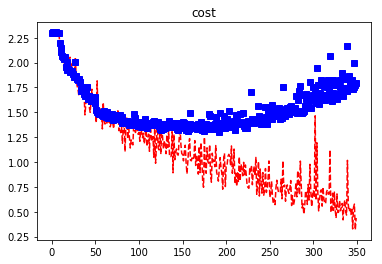

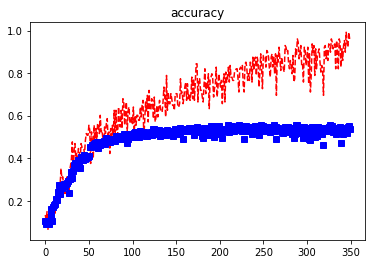

the accuracy on the validation set is:0.5298


In [8]:
# plot the result here
plt.title("cost")
plt.plot(NN.train_cost,'r--', NN.validation_cost, 'bs')
plt.show()
plt.title("accuracy")
plt.plot(NN.train_accuracy,'r--', NN.validation_accuracy, 'bs')
plt.show()
y_predict_validation = NN.predict(X_validation)
accuracy = np.sum((y_predict_validation == y_validation) * 1) / len(y_validation)
print('the accuracy on the validation set is:' + str(accuracy))

In [11]:
# this time train with L2 regulization
# layer_dimensions = [X_train.shape[0], 512, 128, 32, 10]
# NN2 = NeuralNetwork(layer_dimensions, drop_prob=0.2, reg_lambda=0)
NN2.train(X_train, y_train, X_validation, y_validation, iters=10000, alpha=0.01, batch_size=128, print_every=100)
# lambda 0.03, iterations 5000, alpha 0.1. 

the training cost after 0000 iteration is 0.987924:
the training accuracy after 0000 iteration is     0.75:
the validation cost after 0000 iteration is 1.299282:
the validation accuracy after 0000 iteration is     0.55:
the training cost after 0100 iteration is 0.892887:
the training accuracy after 0100 iteration is     0.79:
the validation cost after 0100 iteration is 1.282282:
the validation accuracy after 0100 iteration is     0.56:
the training cost after 0200 iteration is 1.256956:
the training accuracy after 0200 iteration is     0.69:
the validation cost after 0200 iteration is 1.279908:
the validation accuracy after 0200 iteration is     0.56:
the training cost after 0300 iteration is 1.053183:
the training accuracy after 0300 iteration is     0.75:
the validation cost after 0300 iteration is 1.285948:
the validation accuracy after 0300 iteration is     0.56:
the training cost after 0400 iteration is 1.011604:
the training accuracy after 0400 iteration is     0.77:
the validati

the validation cost after 3700 iteration is 1.314149:
the validation accuracy after 3700 iteration is     0.56:
the training cost after 3800 iteration is 0.959999:
the training accuracy after 3800 iteration is     0.73:
the validation cost after 3800 iteration is 1.286299:
the validation accuracy after 3800 iteration is     0.56:
the training cost after 3900 iteration is 0.833135:
the training accuracy after 3900 iteration is     0.75:
the validation cost after 3900 iteration is 1.291842:
the validation accuracy after 3900 iteration is     0.56:
the training cost after 4000 iteration is 1.094595:
the training accuracy after 4000 iteration is     0.72:
the validation cost after 4000 iteration is 1.301411:
the validation accuracy after 4000 iteration is     0.56:
the training cost after 4100 iteration is 1.112215:
the training accuracy after 4100 iteration is     0.70:
the validation cost after 4100 iteration is 1.295544:
the validation accuracy after 4100 iteration is     0.57:
the trai

the training cost after 7500 iteration is 1.032233:
the training accuracy after 7500 iteration is     0.80:
the validation cost after 7500 iteration is 1.292512:
the validation accuracy after 7500 iteration is     0.57:
the training cost after 7600 iteration is 0.951569:
the training accuracy after 7600 iteration is     0.77:
the validation cost after 7600 iteration is 1.286333:
the validation accuracy after 7600 iteration is     0.56:
the training cost after 7700 iteration is 0.952712:
the training accuracy after 7700 iteration is     0.78:
the validation cost after 7700 iteration is 1.295855:
the validation accuracy after 7700 iteration is     0.56:
the training cost after 7800 iteration is 0.895379:
the training accuracy after 7800 iteration is     0.80:
the validation cost after 7800 iteration is 1.283634:
the validation accuracy after 7800 iteration is     0.56:
the training cost after 7900 iteration is 0.829237:
the training accuracy after 7900 iteration is     0.89:
the validati

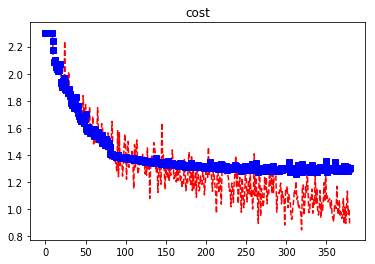

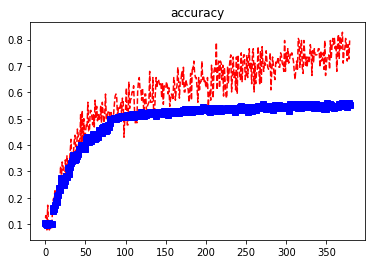

the accuracy on the validation set is:0.5484


In [10]:
# plot the result here
plt.title("cost")
plt.plot(NN2.train_cost,'r--', NN2.validation_cost, 'bs')
plt.show()
plt.title("accuracy")
plt.plot(NN2.train_accuracy,'r--', NN2.validation_accuracy, 'bs')
plt.show()
y_predict_validation = NN2.predict(X_validation)
accuracy = np.sum((y_predict_validation == y_validation) * 1) / len(y_validation)
print('the accuracy on the validation set is:' + str(accuracy))

In [2]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

In [3]:
# Functions to load data, DO NOT change these

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[y] = 1
    return y_one_hot.T

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f)
        img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    X = np.column_stack(images)

    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

In [4]:
# Load the data
data_root_path = '/Users/zhengyixing/Documents/study/3nd_semester/DL/homework/cifar10-hw1/'
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
X_test = get_images(data_root_path + 'test')
print('Data loading done')
indexs = np.random.choice(50000, 5000, replace=False)
X_validation = X_train[:,indexs]
y_validation = y_train[indexs]
X_train = np.delete(X_train,indexs, axis = 1)
y_train = np.delete(y_train,indexs)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loaded 10000/50000
Loaded 20000/50000
Loaded 30000/50000
Loaded 40000/50000
Loaded 50000/50000
Loaded 10000/10000
Data loading done


In [11]:
print(X_train.shape)
print(y_train.shape)
print(y_train)
print(len(y_train))
print(X_test.shape)
print(X_validation.shape)
# try train 
# layer_dimensions = [X_train.shape[0], 32, 10]  # including the input and output layers
# NN = NeuralNetwork(layer_dimensions)
# NN.train(X_train, y_train, iters=1000, alpha=0.0001, batch_size=100, print_every=100)

(3072, 45000)
(45000,)
[6 6 6 ..., 5 1 3]
45000
(3072, 10000)
(3072, 5000)


## Part 1

#### Simple fully-connected deep neural network

In [ ]:
layer_dimensions = [X_train.shape[0], ..., 10]  # including the input and output layers
NN = NeuralNetwork(layer_dimensions)
NN.train(X_train, y_train, iters=, alpha=, batch_size=, print_every=)

In [45]:
# y_predicted = NN.predict(X_test)
y_predicted, _ = NN.forwardPropagation(X_test)
save_predictions('ans1-yz3065', y_predicted)

In [ ]:
# test if your numpy file has been saved correctly
loaded_y = np.load('ans1-uni.npy')
print(loaded_y.shape)
loaded_y[:10]

## Part 2: Regularizing the neural network
#### Add dropout and L2 regularization

In [ ]:
# NN2 = NeuralNetwork(layer_dimensions, drop_prob=0, reg_lambda=0)
# NN2.train(X_train, y_train, iters=1000, alpha=0.00001, batch_size=1000, print_every=10)

In [37]:
y_predicted2 = NN2.forwardPropagation(X_test)
save_predictions('ans2-yz3065', y_predicted2)